In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale, resize
from tqdm import tqdm
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Fusion Tardive
L'objectif de ce notebook est de tester nos résultats en utilisant une technique de fusion tardive.
Le principe est d'utiliser plusieurs classifieurs pour prédire la classe d'uned'image puis de procéder à un vote majoritaire afin de fusionner les prédictions

## Représentation des données
X : liste de noms de fichiers
y : 1 s'il s'agit d'une image de mer, 0 sinon

In [33]:
X = []
y = []
for file in tqdm(os.listdir("./Data/Ailleurs")):
    X.append("./Data/Ailleurs/" + file)
    y.append(0)
for file in tqdm(os.listdir("./Data/Mer")):
    X.append("./Data/Mer/" + file)
    y.append(1)

100%|██████████| 246/246 [00:00<00:00, 2850272.88it/s]


Les dictionnaires suivants ont pour clés un nom de fichier et pour valeur une représentation de ce fichier

In [34]:
histogram_representation = {}
for file in tqdm(X):
    image = Image.open(file)
    image = image.convert("RGB")
    image = image.resize((500,750))
    image = image.crop((0, 250, 500, 750))
    r, g, b = image.split()
    histogram_representation[file] = b.histogram()

100%|██████████| 495/495 [00:03<00:00, 128.32it/s]


In [35]:
hog_representation = {}
for file in tqdm(X):
    image = imread(file, as_gray=True)
    image = resize(image, (1200, 1200))
    image = rescale(image, 1/3, mode='reflect')
    img_hog = hog(image, orientations=16, pixels_per_cell=(16,16),
                    cells_per_block=(1,1), feature_vector=True, block_norm='L2')
    hog_representation[file] = img_hog

100%|██████████| 495/495 [00:35<00:00, 13.96it/s]


In [36]:
from skimage.color import rgb2hsv, rgb2gray
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line

# bleues : 150 -> 240; verts : 75 -> 150; jaunes : 30 -> 65
def color_perc(imarray_rgb, lt, ht):
    # calcul du pourcentage de bleu à l'aide d'un masque
    imarray_rgb = imarray_rgb[:, :, :3]
    imarray_hue = rgb2hsv(imarray_rgb)[:, :, 0] * 360
    nb_px = imarray_hue.shape[0] * imarray_hue.shape[1]
    return np.sum(((imarray_hue > lt) & (imarray_hue < ht)).astype(int)) / nb_px


# rouges: 300 -> 360, 0 -> 30;
def red_perc(imarray_rgb):
    imarray_rgb = imarray_rgb[:, :, :3]
    imarray_hue = rgb2hsv(imarray_rgb)[:, :, 0] * 360
    nb_px = imarray_hue.shape[0] * imarray_hue.shape[1]
    return np.sum(((imarray_hue > 310) | (imarray_hue < 35)).astype(int)) / nb_px

def angle_to_hori(p1, p2):
    # source : https://stackoverflow.com/questions/7586063/how-to-calculate-the-angle-between-a-line-and-the-horizontal-axis
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    theta = np.arctan2(dy, dx)
    return np.degrees(theta)

def compute_hvt_props(imarray):
    """
    Nécessite une image en mode gris
    """
    # source : https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html
    canny_imarray = canny(imarray, 5, 1, 19)  # filtre pour retrouver les contours
    lines = probabilistic_hough_line(canny_imarray, threshold=10, line_length=25, line_gap=10)
    h, v, t = 0, 0, 0
    for p0, p1 in lines:
        angle = np.abs(angle_to_hori(p0, p1))
        if 60 <= angle <= 120 or 240 <= angle <= 300:
            v += 1
        elif 0 <= angle <= 20 or 340 <= angle <= 360 or 160 <= angle <= 200:
            h += 1
        else:
            t += 1
    tot = len(lines) + 1
    return h / tot, v / tot, t / tot, canny_imarray

horizontality_representation = {}
for file in tqdm(X):
    imarray = resize(imread(file), (800, 800), anti_aliasing=True)
    b_perc = color_perc(imarray[250:, :], 175, 280)
    g_perc = color_perc(imarray[:, :], 70, 170)
    r_per = red_perc(imarray)
    imarray_l = rgb2gray(imarray[:, :, :3]) * 255
    # im_blurred = nd.median_filter(imarray_l, size=13)
    h, v, t, _ = compute_hvt_props(imarray_l[150:,:])
    horizontality_representation[file] = [g_perc, b_perc, r_per, h, v, t]

100%|██████████| 495/495 [03:43<00:00,  2.21it/s]


## Classifieurs à fusionner

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

clf_hist = RandomForestClassifier(max_depth=5, min_samples_split=5)
clf_hog = SVC(gamma='auto')
clf_horizontality = RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=5)

## Association classifieur et dictionnaire de représentation des données

In [47]:
classifieurs = {clf_hist: histogram_representation,
                clf_hog : hog_representation,
                clf_horizontality : horizontality_representation}

## Fonction pour fusionner les classes prédites

In [39]:
def majority_voting(predicted_ys):
    y_majority = []
    for i in range(len(y_test)):
        nb_0 = 0
        nb_1 = 0
        for pred in predicted_ys:
            if pred[i] == 0:
                nb_0 += 1
            else:
                nb_1 += 1
        if nb_0 > nb_1:
            y_majority.append(0)
        else:
            y_majority.append(1)
    return y_majority

## Résultats

In [1]:
def plot_results(clf_scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    fig.suptitle('Résultats')
    ax1.hist(clf_scores)
    ax2.boxplot(clf_scores)

    print("Moyenne : " + str(np.mean(clf_scores))+  ", Variance : " + str(np.var(clf_scores)) + ", Écart-type : " + str(np.std(clf_scores)))

100%|██████████| 100/100 [04:25<00:00,  2.66s/it]


Moyenne : 0.791111111111111, Variance : 0.0015608203244566884, Écart-type : 0.039507218637315995


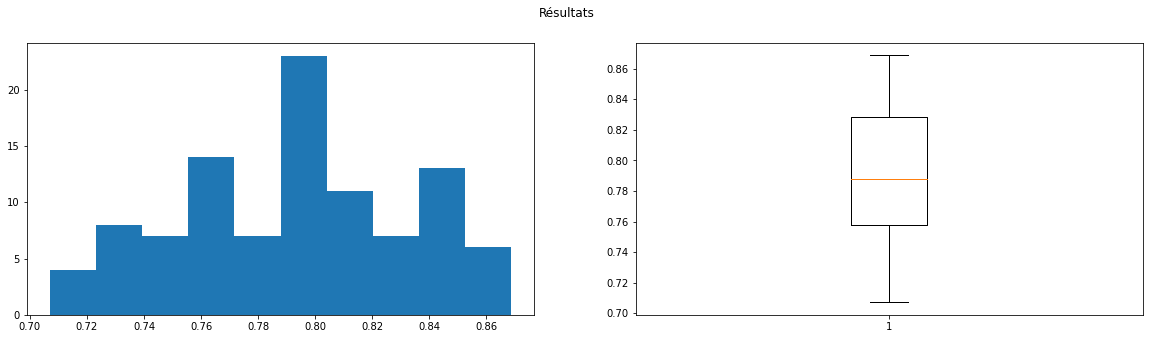

In [53]:
nb_runs = 100
clf_scores = []
for i in tqdm(range(nb_runs)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    predicted_ys = []

    for clf in classifieurs.keys():
        train_representation = []
        for file in X_train:
            train_representation.append(classifieurs[clf][file])

        test_representation = []
        for file in X_test:
            test_representation.append(classifieurs[clf][file])

        clf.fit(train_representation, y_train)
        predicted_ys.append(clf.predict(test_representation))

    y_majority = majority_voting(predicted_ys)
    clf_scores.append(accuracy_score(y_test, y_majority))
plot_results(clf_scores)